In [1]:
try:
    import openmdao.api as om
    import dymos as dm
except ImportError:
    !python -m pip install openmdao[notebooks]
    !python -m pip install dymos[docs]
    import openmdao.api as om
    import dymos as dm

### ODE

Example for a stiff ODE from [Robertson](https://en.wikipedia.org/w/index.php?title=Stiff_equation&oldid=1017928453#Motivating_example)

\begin{align}
    \dot x = &        - 0.04 x + 10^4 y \cdot z &                          \\
    \dot y = & \;\;\;\: 0.04 x - 10^4 y \cdot z &        - 3\cdot 10^7 y^2 \\
    \dot z = &                                  & \;\;\;\: 3\cdot 10^7 y^2 \\
\end{align}

with the inital conditions

\begin{align}
    x_0 &= 1 \\
    y_0 &= z_0 = 0
\end{align}

In [2]:
import numpy as np
import openmdao.api as om
import matplotlib.pyplot as plt

class RobertsonODE(om.ExplicitComponent):
    """example for a stiff ODE from Robertson.
    """

    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']

        # input: state
        self.add_input('x', val=np.ones(nn), desc="state x", units=None)
        self.add_input('y', val=np.ones(nn), desc="state y", units=None)
        self.add_input('z', val=np.ones(nn), desc="state z", units=None)
        
        # output: derivative of state
        self.add_output('xdot', val=np.ones(nn), desc='derivative of x', units="1/s")
        self.add_output('ydot', val=np.ones(nn), desc='derivative of y', units="1/s")
        self.add_output('zdot', val=np.ones(nn), desc='derivative of z', units="1/s")

        r = np.arange(0, nn)
        self.declare_partials(of='*', wrt='*', method='exact',  rows=r, cols=r)

    def compute(self, inputs, outputs):

        x = inputs['x']
        y = inputs['y']
        z = inputs['z']

        xdot = -0.04 * x + 1e4 * y * z
        zdot = 3e7 * y ** 2
        ydot = - ( xdot + zdot )
        
        outputs['xdot'] = xdot
        outputs['ydot'] = ydot
        outputs['zdot'] = zdot
        

    def compute_partials(self, inputs, jacobian):

        x = inputs['x']
        y = inputs['y']
        z = inputs['z']

        xdot_y = 1e4 * z
        xdot_z = 1e4 * y

        zdot_y = 6e7 * y


        jacobian['xdot', 'x'] = -0.04
        jacobian['xdot', 'y'] = xdot_y
        jacobian['xdot', 'z'] = xdot_z

        jacobian['ydot', 'x'] = 0.04
        jacobian['ydot', 'y'] = - ( xdot_y + zdot_y )
        jacobian['ydot', 'z'] = - xdot_z

        jacobian['zdot', 'x'] = 0.0
        jacobian['zdot', 'y'] = zdot_y
        jacobian['zdot', 'z'] = 0.0



In [3]:
num_nodes = 3

p = om.Problem(model=om.Group())

p.model.add_subsystem('ode', RobertsonODE(num_nodes=num_nodes), promotes=['*'])

p.setup(force_alloc_complex=True)

p.set_val('x', np.array([10., 100., 1000.]))
p.set_val('y', np.array([1, 0.1, 0.01]))
p.set_val('z', np.array([1., 2., 3.]))

p.run_model()
cpd = p.check_partials(method='cs', compact_print=True)

-----------------------------
Component: RobertsonODE 'ode'
-----------------------------
'<output>' wrt '<variable>' | calc mag.  | check mag. | a(cal-chk) | r(cal-chk)
-------------------------------------------------------------------------------

'xdot'     wrt 'x'          | 6.9282e-02 | 6.9282e-02 | 1.2019e-17 | 1.7347e-16
'xdot'     wrt 'y'          | 3.7417e+04 | 3.7417e+04 | 0.0000e+00 | 0.0000e+00
'xdot'     wrt 'z'          | 1.0050e+04 | 1.0050e+04 | 1.1369e-13 | 1.1312e-17
'ydot'     wrt 'x'          | 6.9282e-02 | 6.9282e-02 | 1.2019e-17 | 1.7347e-16
'ydot'     wrt 'y'          | 6.0314e+07 | 6.0314e+07 | 0.0000e+00 | 0.0000e+00
'ydot'     wrt 'z'          | 1.0050e+04 | 1.0050e+04 | 1.1369e-13 | 1.1312e-17
'zdot'     wrt 'x'          | 0.0000e+00 | 0.0000e+00 | 0.0000e+00 | nan
'zdot'     wrt 'y'          | 6.0302e+07 | 6.0302e+07 | 0.0000e+00 | 0.0000e+00
'zdot'     wrt 'z'          | 0.0000e+00 | 0.0000e+00 | 0.0000e+00 | nan

##########################################

In [4]:
from dymos.utils.testing_utils import assert_check_partials

assert_check_partials(cpd)

In [5]:
from openmdao.utils.assert_utils import assert_near_equal

assert_near_equal(p.get_val('xdot'), np.array([9999.6, 1996., 260.]))

0.0

In [6]:
from openmdao.utils.assert_utils import assert_near_equal

assert_near_equal(p.get_val('ydot'), np.array([-3.00099996E7, -3.01996E5, -3.26E3]))

1.9395106396345423e-18

In [7]:
from openmdao.utils.assert_utils import assert_near_equal

assert_near_equal(p.get_val('zdot'), np.array([3.0E7, 3.0E5, 3.0E3]))

1.9401583485895875e-18

In [8]:
import openmdao.api as om
import dymos as dm
from dymos.examples.plotting import plot_results
import matplotlib.pyplot as plt

def robertson_problem(t_final=1.):
    #
    # Initialize the Problem
    #
    p = om.Problem(model=om.Group())
    
    #
    # Create a trajectory and add a phase to it
    #
    traj = p.model.add_subsystem('traj', dm.Trajectory())

    phase = traj.add_phase('phase0',
                           dm.Phase(ode_class=RobertsonODE,
                                    transcription=dm.GaussLobatto(num_segments=50)
                                   ))

    #
    # Set the variables
    #
    phase.set_time_options(fix_initial=True, fix_duration=True)

    phase.add_state('x0', fix_initial=True, fix_final=False, rate_source='xdot', targets='x')
    phase.add_state('y0', fix_initial=True, fix_final=False, rate_source='ydot', targets='y')
    phase.add_state('z0', fix_initial=True, fix_final=False, rate_source='zdot', targets='z')

    p.model.linear_solver = om.DirectSolver()

    #
    # Setup the Problem
    #
    p.setup(check=True)

    #
    # Set the initial values
    #
    p['traj.phase0.t_initial'] = 0.0
    p['traj.phase0.t_duration'] = t_final

    p.set_val('traj.phase0.states:x0', phase.interp('x0', ys=[1.0, 0.7]))
    p.set_val('traj.phase0.states:y0', phase.interp('y0', ys=[0.0, 1e-5]))
    p.set_val('traj.phase0.states:z0', phase.interp('z0', ys=[0.0, 0.3]))

    return p


In [9]:
# just set up the problem, test it elsewhere
p = robertson_problem(t_final = 40)

#p.run_driver()
p.run_model()

p_sim = p.model.traj.simulate(method='LSODA')


--- Constraint Report [traj] ---
    --- phase0 ---
        None

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings

Simulating trajectory traj
Done simulating trajectory traj


In [10]:
from openmdao.utils.assert_utils import assert_near_equal

assert_near_equal(p_sim.get_val('traj.phase0.timeseries.states:x0')[-1], 0.71583161, tolerance=1E-8)

6.205138586687484e-09

In [11]:
from openmdao.utils.assert_utils import assert_near_equal

assert_near_equal(p_sim.get_val('traj.phase0.timeseries.states:y0')[-1], 9.18571144e-06, tolerance=1E-9)

2.5210543180338824e-10

In [12]:
from openmdao.utils.assert_utils import assert_near_equal

assert_near_equal(p_sim.get_val('traj.phase0.timeseries.states:z0')[-1], 0.2841592, tolerance=1E-9)

5.393936621887189e-10

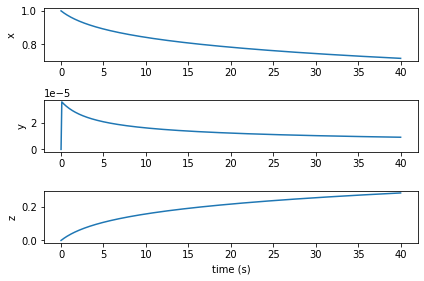

In [13]:
t_sol = p.get_val('traj.phase0.timeseries.time')
t_sim = p_sim.get_val('traj.phase0.timeseries.time')

states = ['x0', 'y0', 'z0']
fig, axes = plt.subplots(len(states), 1)
for i, state in enumerate(states):
    sim = axes[i].plot(t_sim, p_sim.get_val(f'traj.phase0.timeseries.states:{state}'), '-')
    axes[i].set_ylabel(state[0])
axes[-1].set_xlabel('time (s)')
plt.tight_layout()
plt.show()

## References

```{bibliography}
:filter: docname in docnames
```